In [8]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings('ignore')

In [9]:
# Set matplotlib parameters for consistent styling
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [12]:
def get_TPR_maternal(beta, MAF, SR_WT = 0.5, N_rep = 1000, N_cous_pairs = 14015421):
    """
    Calculate the true positive rate (TPR) assuming maternal genetic effect on the sex ratio.
    
    Parameters:
        beta (float): Effect size of the minor allele on sex ratio.
        MAF (float): Minor allele frequency.
        SR_WT (float): Baseline sex ratio in wild type.
        N_rep (int): Number of repetitions for the simulation.
        N_cous_pairs (int): Number of cousin pairs.
        
    Returns:
        TPR (float): True positive rate.
    """
    # Calculate sex ratios based on the effect size
    SR_1M = SR_WT + beta
    SR_2M = SR_WT + 2*beta

    a = MAF
    A = 1-MAF
    
    # Genotype probabilities
    P_AA = A**2
    P_Aa = 2*A*a
    P_aa = a**2
    
    # Proportion of the grandparents having genotype XX and XX. This is talking about the shared grandparents
    # of the cousin pair.
    P_GP_AA_AA = A**4
    P_GP_AA_Aa = 4*(A**3)*a
    P_GP_AA_aa = 2*(A**2)*(a**2)
    P_GP_Aa_Aa = 4*(A**2)*(a**2)
    P_GP_Aa_aa = 4*A*(a**3)
    P_GP_aa_aa = a**4
    
    # Proportion of the parents having genotype XX and XX. This is talking about the parents of 
    # the cousin pair that are children of the grandparents.
    P_Sib_AA_AA = P_GP_AA_AA + (0.5**2)*P_GP_AA_Aa + (0.5**4)*P_GP_Aa_Aa
    P_Sib_AA_Aa = 0.5*P_GP_AA_Aa + (0.5**2)*P_GP_Aa_Aa
    P_Sib_AA_aa = (0.5**3)*P_GP_Aa_Aa
    P_Sib_Aa_Aa = (0.5**2)*P_GP_AA_Aa + P_GP_AA_aa + (0.5**2)*P_GP_Aa_Aa + (0.5**2)*P_GP_Aa_aa
    P_Sib_Aa_aa = (0.5**2)*P_GP_Aa_Aa + 0.5*P_GP_Aa_aa
    P_Sib_aa_aa = (0.5**4)*P_GP_Aa_Aa + (0.5**2)*P_GP_Aa_aa + P_GP_aa_aa
    
    # Proportion of the mothers having genotype XX and XX. This is talking about the mother of 
    # the cousin pair that are not necessarily the children of the grandparents.
    P_mothers_AA_AA = P_Sib_AA_AA * (1/4)*(1 + P_AA + P_AA + P_AA**2) + \
                      P_Sib_AA_Aa * (1/4)*(0 + 0 + P_AA + P_AA**2) + \
                      P_Sib_AA_aa * (1/4)*(0 + 0 + P_AA + P_AA**2) + \
                      P_Sib_Aa_Aa * (1/4)*(0 + 0 + 0 + P_AA**2) + \
                      P_Sib_Aa_aa * (1/4)*(0 + 0 + 0 + P_AA**2) + \
                      P_Sib_aa_aa * (1/4)*(0 + 0 + 0 + P_AA**2)
    
    P_mothers_AA_Aa = P_Sib_AA_AA * (1/4)*(0 + P_Aa + P_Aa + 2*P_Aa*P_AA) + \
                      P_Sib_AA_Aa * (1/4)*(1 + P_AA + P_Aa + 2*P_Aa*P_AA) + \
                      P_Sib_AA_aa * (1/4)*(0 + 0 + P_Aa + 2*P_Aa*P_AA) + \
                      P_Sib_Aa_Aa * (1/4)*(0 + P_AA + P_AA + 2*P_Aa*P_AA) + \
                      P_Sib_Aa_aa * (1/4)*(0 + 0 + P_AA + 2*P_Aa*P_AA) + \
                      P_Sib_aa_aa * (1/4)*(0 + 0 + 0 + 2*P_Aa*P_AA)
    
    P_mothers_AA_aa = P_Sib_AA_AA * (1/4)*(0 + P_aa + P_aa + 2*P_AA*P_aa) + \
                      P_Sib_AA_Aa * (1/4)*(0 + 0 + P_aa + 2*P_AA*P_aa) + \
                      P_Sib_AA_aa * (1/4)*(1 + P_AA + P_aa + 2*P_AA*P_aa) + \
                      P_Sib_Aa_Aa * (1/4)*(0 + 0 + 0 + 2*P_AA*P_aa) + \
                      P_Sib_Aa_aa * (1/4)*(0 + P_AA + 0 + 2*P_AA*P_aa) + \
                      P_Sib_aa_aa * (1/4)*(0 + P_AA + P_AA + 2*P_AA*P_aa)
    
    P_mothers_Aa_Aa = P_Sib_AA_AA * (1/4)*(0 + 0 + 0 + P_Aa**2) + \
                      P_Sib_AA_Aa * (1/4)*(0 + P_Aa + 0 + P_Aa**2) + \
                      P_Sib_AA_aa * (1/4)*(0 + 0 + 0 + P_Aa**2) + \
                      P_Sib_Aa_Aa * (1/4)*(1 + P_Aa + P_Aa + P_Aa**2) + \
                      P_Sib_Aa_aa * (1/4)*(0 + 0 + P_Aa + P_Aa**2) + \
                      P_Sib_aa_aa * (1/4)*(0 + 0 + 0 + P_Aa**2)
    
    P_mothers_Aa_aa = P_Sib_AA_AA * (1/4)*(0 + 0 + 0 + 2*P_Aa*P_aa) + \
                      P_Sib_AA_Aa * (1/4)*(0 + P_aa + 0 + 2*P_Aa*P_aa) + \
                      P_Sib_AA_aa * (1/4)*(0 + P_Aa + 0 + 2*P_Aa*P_aa) + \
                      P_Sib_Aa_Aa * (1/4)*(0 + P_aa + P_aa + 2*P_Aa*P_aa) + \
                      P_Sib_Aa_aa * (1/4)*(1 + P_Aa + P_aa + 2*P_Aa*P_aa) + \
                      P_Sib_aa_aa * (1/4)*(0 + P_Aa + P_Aa + 2*P_Aa*P_aa)
    
    P_mothers_aa_aa = P_Sib_AA_AA * (1/4)*(0 + 0 + 0 + P_aa**2) + \
                      P_Sib_AA_Aa * (1/4)*(0 + 0 + 0 + P_aa**2) + \
                      P_Sib_AA_aa * (1/4)*(0 + P_aa + 0 + P_aa**2) + \
                      P_Sib_Aa_Aa * (1/4)*(0 + 0 + 0 + P_aa**2) + \
                      P_Sib_Aa_aa * (1/4)*(0 + P_aa + 0 + P_aa**2) + \
                      P_Sib_aa_aa * (1/4)*(1 + P_aa + P_aa + P_aa**2)
    
    
    # Proportion of cousion pairs with different combinations of sexes:
    # Male-Male, Male-Female, Female-Male, Female-Female
    P_Cos_M_M = P_mothers_AA_AA * (SR_WT**2) + P_mothers_AA_Aa * (SR_WT*SR_1M) + \
                P_mothers_AA_aa * (SR_WT*SR_2M) + P_mothers_Aa_Aa * (SR_1M*SR_1M) + \
                P_mothers_Aa_aa * (SR_1M*SR_2M) + P_mothers_aa_aa * (SR_2M*SR_2M)

    P_Cos_M_F = P_mothers_AA_AA * (SR_WT*(1-SR_WT)) + \
                0.5 * P_mothers_AA_Aa * ( SR_WT*(1-SR_1M) + (1-SR_WT)*SR_1M ) + \
                0.5 * P_mothers_AA_aa * ( SR_WT*(1-SR_2M) + (1-SR_WT)*SR_2M ) + \
                P_mothers_Aa_Aa * (SR_1M*(1-SR_1M)) + \
                0.5 * P_mothers_Aa_aa * ( SR_1M*(1-SR_2M) + (1-SR_1M)*SR_2M ) + \
                P_mothers_aa_aa * (SR_2M*(1-SR_2M))

    P_Cos_F_M = P_Cos_M_F

    P_Cos_F_F = P_mothers_AA_AA * (1-SR_WT)**2 + P_mothers_AA_Aa * (1-SR_WT)*(1-SR_1M) + \
                P_mothers_AA_aa * (1-SR_WT)*(1-SR_2M) + P_mothers_Aa_Aa * (1-SR_1M)*(1-SR_1M) + \
                P_mothers_Aa_aa * (1-SR_1M)*(1-SR_2M) + P_mothers_aa_aa * (1-SR_2M)*(1-SR_2M)
    
    # Simulation of cousin pairs and chi-squared tests
    P_list = []
    for i in range(N_rep):
        N_Cos_M_M, N_Cos_M_F, N_Cos_F_M, N_Cos_F_F = \
            nrand.multinomial(
                N_cous_pairs,
                [P_Cos_M_M,P_Cos_M_F,P_Cos_F_M,P_Cos_F_F]
            )

        res = stats.chi2_contingency(
            [[N_Cos_M_M, N_Cos_M_F],
            [N_Cos_F_M, N_Cos_F_F]]
        )
        
        P_list.append(res.pvalue)
    
    # Calculate true positive rate
    TPR = (np.array(P_list) < 5e-8).sum() / len(P_list)
    return TPR

In [ ]:
# Parameters for simulation
# 14,015,421 pairs of cousins, 3,543,243 parental individual and their 4,753,269 children.
N_cous_pairs = 14015421
SR_WT = 0.52
N_rep = 1000
beta_list = np.linspace(start=0.005,stop=0.2,num=40)
MAF_list = np.linspace(start=0.0025,stop=0.1,num=40)

# Initialize result array for TPR values
TPR_res_array = np.zeros(shape=[len(beta_list),len(MAF_list)])

# Run the simulation for each combination of beta and MAF
for i,beta in enumerate(beta_list):
    print(f'beta: {beta}')
    for j,MAF in enumerate(MAF_list):
        print(f'MAF: {MAF}',flush=True,end='\r')
        TPR_res_array[i,j] = get_TPR_maternal(beta, MAF, SR_WT = 0.5, N_rep = 1000, N_cous_pairs = 14015421)

In [ ]:
# Save the results
with open('TPR_res_array_Zietsch_maternal.pkl','wb') as f:
    pickle.dump(TPR_res_array,f)

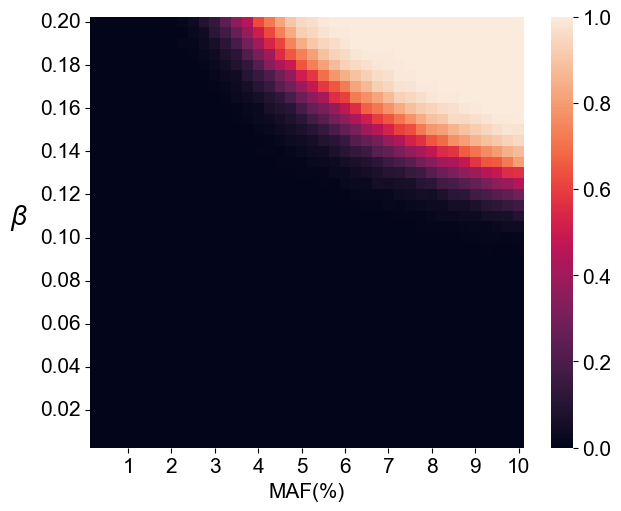

In [57]:
# Plot the results
fig,ax = plt.subplots(figsize=[7,5.6])
ax2 = sns.heatmap(TPR_res_array,)
ax.set_xticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{MAF*100:.0f}' for MAF in np.linspace(start=0.01,stop=0.1,num=10)],rotation=0,fontsize=15)
ax.set_yticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{beta:.2f}' for beta in np.linspace(start=0.02,stop=0.2,num=10)],rotation=0,fontsize=15)
ax.invert_yaxis()

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('MAF(%)',fontsize=15)
ax.set_ylabel('$\mathit{β}$',fontsize=20, rotation=0, labelpad=15)

plt.savefig('Zietsch_power_analysis_maternal.pdf')